## Public/Privat Score:  0.49766/0.49508

# Дневник улучшений

1) Генерация признаков: 0.54

2) Подбор отимальных весов для class_weights: 0.51

3) Интерпретация построенной модели град. бустинга с помощью SHAP-анализа: 0.5035

4) Тюнинг гиперпараметров бустинга и ансамблирование моделей: 0.49811

5) Обучение ансамбля моделей на всех данных без валидации: 0.49766


In [323]:
import pandas as pd
import numpy as np
from datetime import timedelta

import catboost
from catboost import CatBoostClassifier
import lightgbm as lgb

from sklearn.model_selection import train_test_split

import optuna
import shap
from scipy.optimize import minimize

In [35]:
df_train = pd.read_parquet("train.pa")
transactions_df = pd.read_parquet("df_transaction.pa")

In [36]:
# Определяем клиентов в тесте
test_clients = (
    transactions_df.loc[~transactions_df.client_num.isin(df_train.client_num), "client_num"]
    .unique()
)

## Генерация признаков

Были созданы следующие признаки:

### 1. Базовые финансовые показатели
| Название признака | Описание |
|-------------------|----------|
| num_transactions | Общее количество транзакций |
| avg_amount | Средняя сумма транзакции |
| min_amount | Минимальная сумма транзакции |
| max_amount | Максимальная сумма транзакции |
| std_amount | Стандартное отклонение суммы транзакции |
| median_amount | Медианная сумма транзакции |
| total_amount | Общая сумма всех транзакций |
| q25_amount | 25-й перцентиль суммы транзакции |
| q75_amount | 75-й перцентиль суммы транзакции |
| transactions_above_500 | Количество транзакций > 500 руб |
| transactions_above_1000 | Количество транзакций > 1000 руб |
| transactions_above_2000 | Количество транзакций > 2000 руб |
| transactions_above_5000 | Количество транзакций > 5000 руб |
| transactions_above_10000 | Количество транзакций > 10000 руб |
| transactions_above_20000 | Количество транзакций > 20000 руб |
| transactions_above_50000 | Количество транзакций > 50000 руб |
| transactions_above_100000 | Количество транзакций > 100000 руб |
| transactions_above_200000 | Количество транзакций > 200000 руб |

### 2. Временные паттерны
| Название признака | Описание |
|-------------------|----------|
| weekday_transactions | Количество транзакций в будние дни |
| weekend_transactions | Количество транзакций в выходные дни |
| morning_transactions | Количество транзакций утром (6-12) |
| afternoon_transactions | Количество транзакций днем (12-18) |
| evening_transactions | Количество транзакций вечером (18-24) |
| night_transactions | Количество транзакций ночью (0-6) |
| weekday_sum | Сумма транзакций в будние дни |
| weekend_sum | Сумма транзакций в выходные дни |
| most_common_hour | Самый частый час транзакции (мода) |
| transaction_hour_std | Стандартное отклонение часа транзакции |
| weekend_weekday_ratio | Отношение суммы выходных к сумме будних |
| weekday_weekend_ratio | Отношение суммы будних к сумме выходных |
| evening_night_ratio | Отношение количества вечерних транзакций к ночным |

### 3. Активность по месяцам
| Название признака | Описание |
|-------------------|----------|
| month_1_count | Количество транзакций в январе |
| month_2_count | Количество транзакций в феврале |
| ... | ... (аналогично для месяцев 3-12) |
| month_12_count | Количество транзакций в декабре |
| month_1_sum | Сумма транзакций в январе |
| month_2_sum | Сумма транзакций в феврале |
| ... | ... (аналогично для месяцев 3-12) |
| month_12_sum | Сумма транзакций в декабре |
| month_1_ratio | Доля транзакций в январе от общего числа |
| month_2_ratio | Доля транзакций в феврале от общего числа |
| ... | ... (аналогично для месяцев 3-12) |
| month_12_ratio | Доля транзакций в декабре от общего числа |

### 4. Категориальные признаки
| Название признака | Описание |
|-------------------|----------|
| unique_mcc | Количество уникальных MCC-кодов |
| unique_merchants | Количество уникальных мерчантов |
| most_common_mcc | Самый частый MCC-код |
| most_common_mcc_freq | Доля транзакций с самым частым MCC-кодом |
| most_common_merchant | Самый частый мерчант |
| most_common_merchant_freq | Доля транзакций с самым частым мерчантом |

### 5. Поведенческие характеристики
| Название признака | Описание |
|-------------------|----------|
| min_time_diff_seconds | Минимальный интервал между транзакциями (сек) |
| max_time_diff_seconds | Максимальный интервал между транзакциями (сек) |
| median_time_diff_seconds | Медианный интервал между транзакциями (сек) |
| mean_time_diff_seconds | Средний интервал между транзакциями (сек) |
| first_transaction | Порядковый номер даты первой транзакции |
| last_transaction | Порядковый номер даты последней транзакции |
| recency_days | Дней с последней транзакции до даты среза |
| unique_days | Количество уникальных дней с транзакциями |
| activity_duration | Продолжительность активности (дни) |
| median_transaction_hour | Час медианной транзакции |
| transaction_frequency | Частота транзакций (транзакций/день) |

### 6. Топ MCC признаки (топ-320)
| Название признака | Описание |
|-------------------|----------|
| mcc_{code}_count | Количество транзакций для MCC-кода {code} |
| mcc_{code}_sum | Сумма транзакций для MCC-кода {code} |

### 7. Топ мерчанты (топ-320)
| Название признака | Описание |
|-------------------|----------|
| merch_{merchant}_count | Количество транзакций для мерчанта {merchant} |
| merch_{merchant}_sum | Сумма транзакций для мерчанта {merchant} |

### 8. Активность в последние периоды
| Название признака | Описание |
|-------------------|----------|
| recent_transactions_1 | Количество транзакций за последние 1 день |
| recent_transactions_2 | Количество транзакций за последние 2 дня |
| recent_transactions_3 | Количество транзакций за последние 3 дня |
| recent_transactions_5 | Количество транзакций за последние 5 дней |
| recent_transactions_7 | Количество транзакций за последние 7 дней |
| recent_transactions_14 | Количество транзакций за последние 14 дней |
| recent_transactions_21 | Количество транзакций за последние 21 день |
| recent_transactions_30 | Количество транзакций за последние 30 дней |
| recent_total_amount_1 | Сумма транзакций за последние 1 день |
| recent_total_amount_2 | Сумма транзакций за последние 2 дня |
| ... | ... (аналогично для всех периодов) |
| recent_total_amount_30 | Сумма транзакций за последние 30 дней |
| recent_avg_amount_1 | Средняя сумма транзакции за последние 1 день |
| recent_avg_amount_2 | Средняя сумма транзакции за последние 2 дня |
| ... | ... (аналогично для всех периодов) |
| recent_avg_amount_30 | Средняя сумма транзакции за последние 30 дней |
| recent_activity_ratio_1 | Доля транзакций за последние 1 день |
| recent_activity_ratio_2 | Доля транзакций за последние 2 дня |
| ... | ... (аналогично для всех периодов) |
| recent_activity_ratio_30 | Доля транзакций за последние 30 дней |

In [56]:
# ========== Извлечение временных признаков ==========
transactions_df['hour'] = transactions_df['date_time'].dt.hour
transactions_df['day_of_week'] = transactions_df['date_time'].dt.dayofweek
transactions_df['is_weekend'] = (transactions_df['day_of_week'] >= 5).astype('int')
transactions_df['month'] = transactions_df['date_time'].dt.month
transactions_df['date'] = transactions_df['date_time'].dt.date

def get_time_period(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 24:
        return 'evening'
    else:
        return 'night'

transactions_df['time_period'] = transactions_df['hour'].apply(get_time_period).astype('category')

# ========== Базовые финансовые показатели ==========
amount_thresholds = [500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]
financial_features = pd.DataFrame()
financial_features['client_num'] = transactions_df['client_num'].unique()

# Базовые финансовые метрики
base_features = transactions_df.groupby('client_num').agg(
    num_transactions=('date_time', 'count'),
    avg_amount=('amount', 'mean'),
    min_amount=('amount', 'min'),
    max_amount=('amount', 'max'),
    std_amount=('amount', 'std'),
    median_amount=('amount', 'median'),
    total_amount=('amount', 'sum'),
    q25_amount=('amount', lambda x: x.quantile(0.25)),
    q75_amount=('amount', lambda x: x.quantile(0.75))
).reset_index()

financial_features = financial_features.merge(base_features, on='client_num', how='left')

# Пороговые признаки
for thresh in amount_thresholds:
    above_threshold = transactions_df[transactions_df['amount'] > thresh].groupby('client_num').size().reset_index(name=f'transactions_above_{thresh}')
    financial_features = financial_features.merge(above_threshold, on='client_num', how='left').fillna({f'transactions_above_{thresh}': 0})

# ========== Временные паттерны ==========
time_features = transactions_df.groupby('client_num').agg(
    weekday_transactions=('is_weekend', lambda x: (x == 0).sum()),
    weekend_transactions=('is_weekend', lambda x: (x == 1).sum()),
    morning_transactions=('time_period', lambda x: (x == 'morning').sum()),
    afternoon_transactions=('time_period', lambda x: (x == 'afternoon').sum()),
    evening_transactions=('time_period', lambda x: (x == 'evening').sum()),
    night_transactions=('time_period', lambda x: (x == 'night').sum()),
    weekday_sum=('amount', lambda x: x[transactions_df.loc[x.index, 'is_weekend'] == 0].sum()),
    weekend_sum=('amount', lambda x: x[transactions_df.loc[x.index, 'is_weekend'] == 1].sum()),
    most_common_hour=('hour', lambda x: x.mode()[0] if not x.mode().empty else -1),
    transaction_hour_std=('hour', 'std')
).reset_index().fillna(0)

# Финансовые отношения
time_features['weekend_weekday_ratio'] = time_features['weekend_sum'] / (time_features['weekday_sum'] + 1e-6)
time_features['weekday_weekend_ratio'] = time_features['weekday_sum'] / (time_features['weekend_sum'] + 1e-6)
time_features['evening_night_ratio'] = (time_features['evening_transactions'] + 1) / (time_features['night_transactions'] + 1)

# ========== Активность по месяцам ==========
# Создаем временный DataFrame с активностью по месяцам
monthly_counts = transactions_df.groupby(['client_num', 'month']).size().reset_index(name='count')
monthly_sums = transactions_df.groupby(['client_num', 'month'])['amount'].sum().reset_index(name='sum')

# Формируем фичи в широком формате
monthly_counts_wide = monthly_counts.pivot(index='client_num', columns='month', values='count').fillna(0)
monthly_sums_wide = monthly_sums.pivot(index='client_num', columns='month', values='sum').fillna(0)

# Переименовываем колонки
months = monthly_counts_wide.columns
monthly_counts_wide.columns = [f'month_{int(month)}_count' for month in months]
monthly_sums_wide.columns = [f'month_{int(month)}_sum' for month in months]

# Рассчитываем доли
total_counts = monthly_counts_wide.sum(axis=1)
monthly_ratios = monthly_counts_wide.div(total_counts, axis=0)
monthly_ratios.columns = [f'month_{int(month)}_ratio' for month in months]

# Объединяем все месячные фичи
monthly_features = pd.concat([monthly_counts_wide, monthly_sums_wide, monthly_ratios], axis=1).reset_index()

# ========== Категориальные признаки ==========
categorical_features = transactions_df.groupby('client_num').agg(
    unique_mcc=('mcc_code', 'nunique'),
    unique_merchants=('merchant_name', 'nunique'),
    most_common_mcc=('mcc_code', lambda x: x.value_counts().index[0]),
    most_common_mcc_freq=('mcc_code', lambda x: x.value_counts().iloc[0] / len(x)),
    most_common_merchant=('merchant_name', lambda x: x.value_counts().index[0]),
    most_common_merchant_freq=('merchant_name', lambda x: x.value_counts().iloc[0] / len(x))
).reset_index()

# ========== Поведенческие характеристики ==========
snapshot_date = transactions_df['date_time'].max() + pd.Timedelta(days=1)
transactions_sorted = transactions_df.sort_values(['client_num', 'date_time'])

def calculate_behavior_features(group):
    group = group.sort_values('date_time')
    first_tx = group['date_time'].min()
    last_tx = group['date_time'].max()
    
    if len(group) > 1:
        diffs = group['date_time'].diff().dt.total_seconds()
        min_diff = diffs.min()
        max_diff = diffs.max()
        median_diff = diffs.median()
        mean_diff = diffs.mean()
    else:
        min_diff = max_diff = median_diff = mean_diff = 0
    
    recency_days = (snapshot_date - last_tx).days
    unique_days = group['date'].nunique()
    median_time = group['date_time'].median()
    
    return pd.Series({
        'min_time_diff_seconds': min_diff,
        'max_time_diff_seconds': max_diff,
        'median_time_diff_seconds': median_diff,
        'mean_time_diff_seconds': mean_diff,
        'first_transaction': first_tx,
        'last_transaction': last_tx,
        'recency_days': recency_days,
        'unique_days': unique_days,
        'median_transaction_time': median_time
    })

time_diff_features = transactions_sorted.groupby('client_num').apply(calculate_behavior_features).reset_index()
time_diff_features['activity_duration'] = (time_diff_features['last_transaction'] - time_diff_features['first_transaction']).dt.days + 1
time_diff_features['median_transaction_hour'] = time_diff_features['median_transaction_time'].dt.hour
time_diff_features.drop('median_transaction_time', axis=1, inplace=True)
time_diff_features['transaction_frequency'] = financial_features['num_transactions'] / time_diff_features['activity_duration'].replace(0, 1)

# ========== Топ MCC и Мерчанты ==========
def add_top_features(df, column, prefix, n=320):
    top_values = df[column].value_counts().head(n).index
    features = pd.DataFrame({'client_num': df['client_num'].unique()})
    
    for value in top_values:
        # Для мерчантов заменяем проблемные символы
        safe_value = str(value).replace(' ', '_').replace('/', '_').replace('\\', '_').replace('.', '_')
        
        # Количество транзакций
        count_df = df[df[column] == value].groupby('client_num').size().reset_index(name=f'{prefix}_{safe_value}_count')
        features = features.merge(count_df, on='client_num', how='left')
        
        # Сумма транзакций
        sum_df = df[df[column] == value].groupby('client_num')['amount'].sum().reset_index(name=f'{prefix}_{safe_value}_sum')
        features = features.merge(sum_df, on='client_num', how='left')
    
    return features.fillna(0)

top_mcc_features = add_top_features(transactions_df, 'mcc_code', 'mcc')
top_merchant_features = add_top_features(transactions_df, 'merchant_name', 'merch')

# ========== Активность в последние периоды ==========
max_date = transactions_df['date_time'].max()
periods = [30, 21, 14, 7, 5, 3, 2, 1]
recent_activities = {}

for period in periods:
    last_n_days = transactions_df[transactions_df['date_time'] > (max_date - timedelta(days=period))]
    activity = last_n_days.groupby('client_num').agg(
        **{
            f'recent_transactions_{period}': ('date_time', 'count'),
            f'recent_total_amount_{period}': ('amount', 'sum'),
            f'recent_avg_amount_{period}': ('amount', 'mean')
        }
    ).reset_index()
    recent_activities[period] = activity

# ========== Объединение всех признаков ==========
features = financial_features.merge(time_features, on='client_num', how='left')
features = features.merge(categorical_features, on='client_num', how='left')
features = features.merge(time_diff_features, on='client_num', how='left')
features = features.merge(monthly_features, on='client_num', how='left')
features = features.merge(top_mcc_features, on='client_num', how='left')
features = features.merge(top_merchant_features, on='client_num', how='left')

# Добавление активности за периоды
for period in periods:
    features = features.merge(recent_activities[period], on='client_num', how='left')
    features[f'recent_activity_ratio_{period}'] = (
        features[f'recent_transactions_{period}'] / 
        features['num_transactions'].replace(0, 1)
    )

# ========== Заполнение пропусков ==========
features['std_amount'].fillna(0, inplace=True)
features['transaction_hour_std'].fillna(0, inplace=True)

# Преобразование дат в порядковые числа
if 'first_transaction' in features.columns:
    features['first_transaction'] = features['first_transaction'].apply(lambda x: x.toordinal() if pd.notnull(x) else 0)
if 'last_transaction' in features.columns:
    features['last_transaction'] = features['last_transaction'].apply(lambda x: x.toordinal() if pd.notnull(x) else 0)

# Заполнение пропусков в периодических фичах
for period in periods:
    for col in [f'recent_transactions_{period}', 
                f'recent_total_amount_{period}', 
                f'recent_avg_amount_{period}']:
        if col in features.columns:
            features[col].fillna(0, inplace=True)

In [82]:
final_data = df_train.merge(features, on='client_num', how='left')
test = features.loc[features.client_num.isin(test_clients)]

Разделим на обучающую и валидационные выборку.

In [83]:
X = final_data.drop(['client_num', 'target','most_common_merchant'], axis=1)
y = final_data.target
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, 
                                                  stratify=y)

Создаем Pool для CatBoost

In [84]:
train_pool = catboost.Pool(
    X_train,
    label=y_train,
)
eval_pool = catboost.Pool(
    X_val,
    label=y_val,
)

Создаем Dataset для LightGBM

In [212]:
# Веса классов
base_weights = np.array([0.7900, 0.9220, 0.9820, 0.6070, 0.3870, 0.2190, 0.1540]),

# Создаем веса для образцов
train_weights = np.array([base_weights[0][y] for y in y_train])
val_weights = np.array([base_weights[0][y] for y in y_val])

X_train['most_common_mcc'] = X_train.loc[:, 'most_common_mcc'].astype('int')
X_val['most_common_mcc'] = X_val.loc[:, 'most_common_mcc'].astype('int')
test['most_common_mcc'] = test.loc[:, 'most_common_mcc'].astype('int')

train_data = lgb.Dataset(X_train, label=y_train, weight=train_weights)
val_data = lgb.Dataset(X_val, label=y_val, weight=val_weights, reference=train_data)

## Подбор отимальных весов для class_weights

Дальше подберем оптимальные веса классов. Идея заключается в том, что вставлять в модель в class_weights наши оригинальные веса не лучшая идея для получения минимального wmae. В действительности, получилось улучшить скор с 0.54 (базовый CatBoostClassifier c class_weights=[1.0, 0.72, 0.52, 0.37, 0.27, 0.19, 0.14]) до 0.51, испрользуя подобранные параметры.

In [59]:
def weighted_mae(y_true, y_pred):
    weights_dict = {0: 1.0, 1: 0.72, 2: 0.52, 3: 0.37, 4: 0.27, 5: 0.19, 6: 0.14}
    weights = np.array([weights_dict[c] for c in y_true])
    return np.sum(weights * np.abs(y_true - y_pred)) / len(y_true)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
   

# Оригинальные веса
base_weights = [1.0, 0.72, 0.52, 0.37, 0.27, 0.19, 0.14]

def objective(trial):
    # Генерируем веса на основе оригинальных с вариациями
    class_weights = [
        trial.suggest_float(f'weight_{i}', 
                           max(0.01, base_weights[i] * 0.1), 
                           min(2.0, base_weights[i] * 1.9),
                           step=0.01)
        for i in range(7)
    ]
    
    params = {
        'iterations': 1000,
        'random_state': 42,
        'early_stopping_rounds': 50,
        'verbose': False,
        'task_type': 'GPU',
        'class_weights': class_weights,
    }
    
    model = CatBoostClassifier(**params)
    model.fit(
        train_pool,
        eval_set=eval_pool,
        use_best_model=True
    )
    
    
    return weighted_mae(y_val, model.predict(X_val).ravel())

# Оптимизация
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500, show_progress_bar=True)

В итоге, получили следующие наилучшие параметры:

Weights:

    Class 0: 0.7900
    Class 1: 0.9220
    Class 2: 0.9820
    Class 3: 0.6070
    Class 4: 0.3870
    Class 5: 0.2190
    Class 6: 0.1540

## Интерпретация построенной модели град. бустинга

Теперь с помощью SHAP-анализа найдем и уберем маловажные признаки.

### CatBoost

In [116]:
model = CatBoostClassifier(
    class_weights=[0.7900, 0.9220, 0.9820, 0.6070, 0.3870, 0.2190, 0.1540],
    iterations=1000,
    random_state=42,
    verbose=100,
    early_stopping_rounds=100,
)
model.fit(train_pool,
          eval_set=eval_pool,
        use_best_model=True)

Learning rate set to 0.117028
0:	learn: 1.8527556	test: 1.8536560	best: 1.8536560 (0)	total: 406ms	remaining: 6m 45s
100:	learn: 1.4037133	test: 1.4405438	best: 1.4405438 (100)	total: 28.1s	remaining: 4m 10s
200:	learn: 1.3641415	test: 1.4327920	best: 1.4327502 (199)	total: 54.5s	remaining: 3m 36s
300:	learn: 1.3352018	test: 1.4302841	best: 1.4302841 (300)	total: 1m 20s	remaining: 3m 6s
400:	learn: 1.3118862	test: 1.4298376	best: 1.4297963 (353)	total: 1m 45s	remaining: 2m 36s
500:	learn: 1.2897737	test: 1.4290455	best: 1.4289708 (484)	total: 2m 11s	remaining: 2m 10s
600:	learn: 1.2697967	test: 1.4290117	best: 1.4286444 (574)	total: 2m 36s	remaining: 1m 43s
700:	learn: 1.2499562	test: 1.4289183	best: 1.4285598 (624)	total: 3m 1s	remaining: 1m 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.428559847
bestIteration = 624

Shrink model to first 625 iterations.


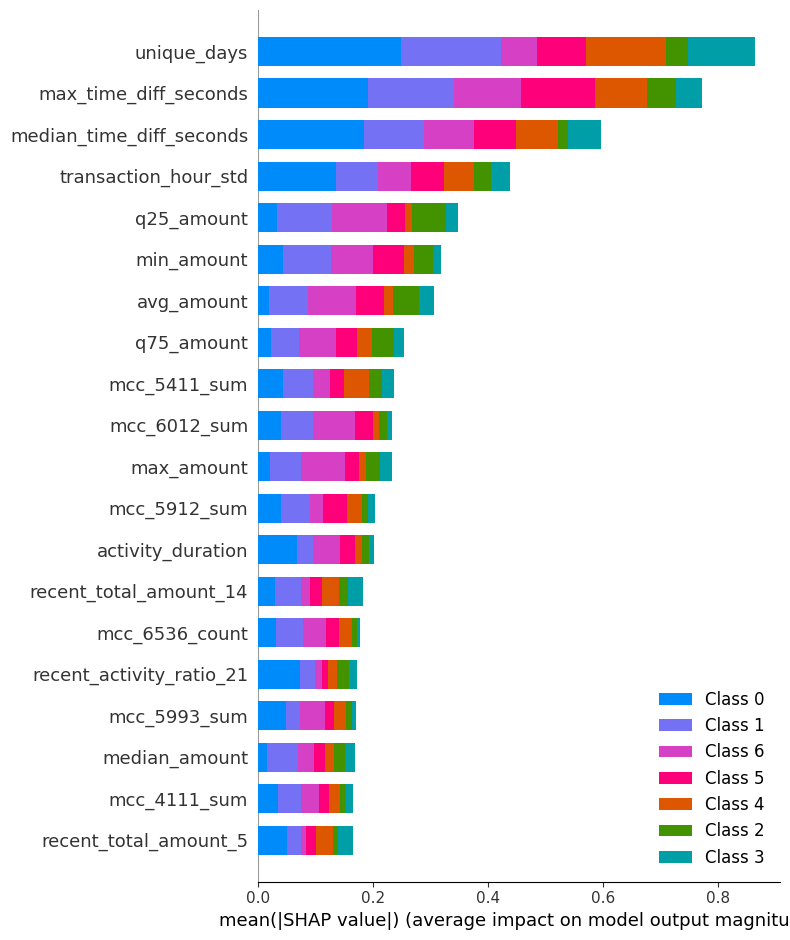

In [88]:
# SHAP-анализ
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

# Визуализация важности признаков
shap.summary_plot(shap_values, X_val, plot_type="bar")

In [152]:
# Удаление признаков с малой важностью
feature_importance = pd.Series(np.abs(shap_values).mean(axis=0).sum(axis=1), index=X_val.columns)
cols_to_drop = feature_importance[feature_importance <= 0.00075].index.tolist()
X_train_reduced = X_train.drop(cols_to_drop, axis=1)
X_val_reduced = X_val.drop(cols_to_drop, axis=1)

train_pool_reduced = catboost.Pool(
    X_train_reduced,
    label=y_train,
)
eval_pool_reduced = catboost.Pool(
    X_val_reduced,
    label=y_val,
)

# Переобучение на сокращенных данных
model = CatBoostClassifier(
    class_weights=[0.7900, 0.9220, 0.9820, 0.6070, 0.3870, 0.2190, 0.1540],
    iterations=1000,
    random_state=42,
    verbose=100,
    early_stopping_rounds=100,
)
model.fit(train_pool_reduced,
          eval_set=eval_pool_reduced,
        use_best_model=True)

Learning rate set to 0.117028
0:	learn: 1.8579920	test: 1.8580957	best: 1.8580957 (0)	total: 312ms	remaining: 5m 11s
100:	learn: 1.4002550	test: 1.4388208	best: 1.4388208 (100)	total: 23.9s	remaining: 3m 32s
200:	learn: 1.3584296	test: 1.4303503	best: 1.4303503 (200)	total: 39.5s	remaining: 2m 37s
300:	learn: 1.3266486	test: 1.4283030	best: 1.4281137 (283)	total: 54.4s	remaining: 2m 6s
400:	learn: 1.3002688	test: 1.4278261	best: 1.4277453 (349)	total: 1m 9s	remaining: 1m 44s
500:	learn: 1.2757305	test: 1.4280183	best: 1.4273951 (449)	total: 1m 24s	remaining: 1m 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.427395117
bestIteration = 449

Shrink model to first 450 iterations.


In [153]:
weighted_mae(y_val, model.predict(X_val).ravel())

0.50354

### LightGBM

In [231]:
params = {
    'objective': 'multiclass',
    'num_class': 7,
    'n_estimators': 1000, 
    'random_state': 42,
}
model = lgb.train(
    params,
    train_data,
    valid_sets=[val_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100, verbose=True),
    ]
)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 1.43982


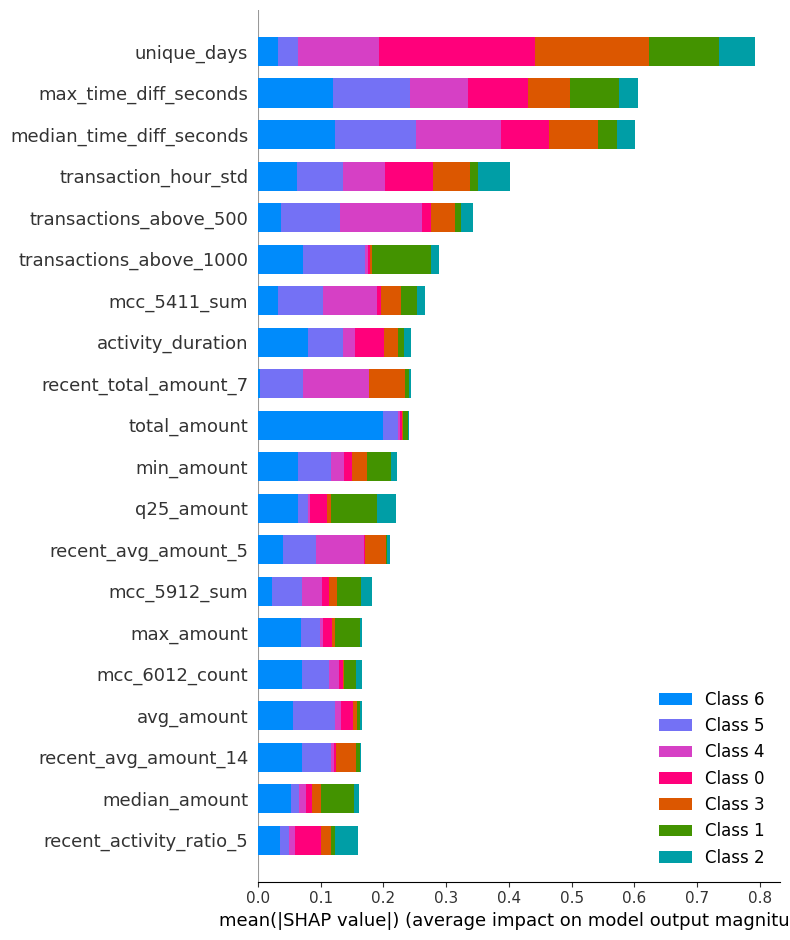

In [233]:
# SHAP-анализ
explainer_lgbm = shap.TreeExplainer(model)
shap_values_lgbm = explainer_lgbm.shap_values(X_val)

# Визуализация важности признаков
shap.summary_plot(shap_values_lgbm, X_val, plot_type="bar")

In [263]:
# Удаление признаков с малой важностью
feature_importance_lgbm = pd.Series(np.abs(shap_values_lgbm).mean(axis=0).sum(axis=1), index=X_val.columns)
cols_to_drop_lgbm = feature_importance_lgbm[feature_importance_lgbm <= 0.005].index.tolist()
X_train_reduced_lgbm = X_train.drop(cols_to_drop_lgbm, axis=1)
X_val_reduced_lgbm = X_val.drop(cols_to_drop_lgbm, axis=1)

train_data_reduced = lgb.Dataset(X_train_reduced_lgbm, label=y_train, weight=train_weights)
val_data_reduced = lgb.Dataset(X_val_reduced_lgbm, label=y_val, weight=val_weights, 
                               reference=train_data_reduced)

# Переобучение на сокращенных данных
model = lgb.train(
    params,
    train_data_reduced,
    valid_sets=[val_data_reduced],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True),
    ]
)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 1.4386


In [244]:
weighted_mae(y_val, np.argmax(model.predict(X_val_reduced_lgbm), axis=1))

0.5113428571428572

## Тюнинг гиперпараметров бустинга

С помощью optuna подберем гиперпараметры для CatBoost.

In [155]:
def objective(trial):
    params = {
        'iterations': 1000,
        'depth': trial.suggest_int('depth', 4, 10),
        'eta': trial.suggest_float('eta', 0.001, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 10, log=True),
        'random_state': 42,
        'early_stopping_rounds': 50,
        'verbose': False,
        'class_weights': [0.7900, 0.9220, 0.9820, 0.6070, 0.3870, 0.2190, 0.1540],
    }

    model = CatBoostClassifier(**params)
    model.fit(train_pool_reduced,
          eval_set=eval_pool_reduced,
          use_best_model=True)

    return weighted_mae(y_val, model.predict(X_val).ravel())

# Оптимизация
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2025-07-10 03:30:15,547] A new study created in memory with name: no-name-fb6a34a5-fdd1-4536-9923-3e0edc96600b


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-07-10 03:35:26,998] Trial 0 finished with value: 0.51006 and parameters: {'depth': 10, 'eta': 0.04958254530109517, 'l2_leaf_reg': 8.267852559927581e-05}. Best is trial 0 with value: 0.51006.
[I 2025-07-10 03:43:00,381] Trial 1 finished with value: 0.5070635714285715 and parameters: {'depth': 7, 'eta': 0.0310190357018343, 'l2_leaf_reg': 0.06805125987251939}. Best is trial 1 with value: 0.5070635714285715.
[I 2025-07-10 03:45:47,979] Trial 2 finished with value: 0.50992 and parameters: {'depth': 6, 'eta': 0.006020413734742897, 'l2_leaf_reg': 0.0005065573069802006}. Best is trial 1 with value: 0.5070635714285715.
[I 2025-07-10 03:59:01,248] Trial 3 finished with value: 0.5093807142857143 and parameters: {'depth': 10, 'eta': 0.020553336978992368, 'l2_leaf_reg': 0.0001111052586913435}. Best is trial 1 with value: 0.5070635714285715.
[I 2025-07-10 04:01:04,430] Trial 4 finished with value: 0.5115200000000001 and parameters: {'depth': 4, 'eta': 0.006610408215701838, 'l2_leaf_reg': 0.0

Дальше подберем гиперпараметры для LightGBM.

In [267]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'objective': 'multiclass',
        'num_class': 7,
        'n_estimators': 1000, 
        'random_state': 42,
        'verbosity': -1,
    }
    model = lgb.train(
        params,
        train_data_reduced,
        valid_sets=[val_data_reduced],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),
        ]
    )

    return weighted_mae(y_val, np.argmax(model.predict(X_val_reduced_lgbm), axis=1))

# Оптимизация
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2025-07-10 18:43:27,687] A new study created in memory with name: no-name-ead55f8f-77bf-4a2b-8bf7-9f46c2dacd9d


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-07-10 18:44:57,044] Trial 0 finished with value: 0.5171964285714286 and parameters: {'max_depth': 7, 'learning_rate': 0.0013503127825370406, 'reg_alpha': 0.002537353945805913, 'reg_lambda': 0.05803688563697082}. Best is trial 0 with value: 0.5171964285714286.
[I 2025-07-10 18:45:21,967] Trial 1 finished with value: 0.5109371428571428 and parameters: {'max_depth': 4, 'learning_rate': 0.022754098432370987, 'reg_alpha': 0.3513036893908982, 'reg_lambda': 2.80750990430169e-06}. Best is trial 1 with value: 0.5109371428571428.
[I 2025-07-10 18:45:38,643] Trial 2 finished with value: 0.5091478571428572 and parameters: {'max_depth': 4, 'learning_rate': 0.03503716438786625, 'reg_alpha': 0.05712933841387549, 'reg_lambda': 0.26142551852039475}. Best is trial 2 with value: 0.5091478571428572.
[I 2025-07-10 18:45:45,298] Trial 3 finished with value: 0.5152599999999999 and parameters: {'max_depth': 6, 'learning_rate': 0.11677790960292908, 'reg_alpha': 1.0213215571017507e-05, 'reg_lambda': 0.2

В итоге были выбраны 7 моделей CatBoost и 2 модели LightGBM.

<div style="text-align: center; font-weight: bold;">CatBoost Models Parameters</div>

| Model      | depth | learning_rate | l2_leaf_reg |
|:----------:|:-----:|:-------------:|:-----------:|
| CatBoost 1 | 5     | 0.02870       | 0.13805     |
| CatBoost 2 | 6     | 0.03955       | 3.14714     |
| CatBoost 3 | 7     | 0.03723       | 1.18692     |
| CatBoost 4 | 4     | 0.03117       | 1.15255     |
| CatBoost 5 | 5     | 0.05825       | 0.32427     |
| CatBoost 6 | 7     | 0.03881       | 9.25315     |
| CatBoost 7 | 5     | 0.02145       | 0.05280     |


<div style="text-align: center; font-weight: bold;">LightGBM Models Parameters</div>

| Model      | max_depth | learning_rate | reg_alpha | reg_lambda |
|:----------:|:---------:|:-------------:|:---------:|:----------:|
| LightGBM 1 | 4         | 0.00941       | 3.79e-08  | 0.35645    |
| LightGBM 2 | 4         | 0.00902       | 4.41e-08  | 0.00614    |

## Обучение ансамбля моделей

Обучим ансамбль моделей, выбранных выше.

In [282]:
best_params = [
    {
        'depth': 5,
        'learning_rate': 0.028696624117851774,
        'l2_leaf_reg': 0.13805253355908462,
    },
    {
        'depth': 6,
        'learning_rate': 0.039553792355248,
        'l2_leaf_reg': 3.147140381141612,
    },
    {
        'depth': 7,
        'learning_rate': 0.03722725810673189,
        'l2_leaf_reg': 1.186916028751397,
    },
    {
        'depth': 4,
        'learning_rate': 0.031169517856212667,
        'l2_leaf_reg': 1.1525543265620801,
    },
    {
        'depth': 5,
        'learning_rate': 0.05825031634504199,
        'l2_leaf_reg': 0.3242744895010619,
    },
        {
        'depth': 7,
        'learning_rate': 0.03881112040229251,
        'l2_leaf_reg': 9.253154590525618,
    },
        {
        'depth': 5,
        'learning_rate': 0.021448699623418263,
        'l2_leaf_reg': 0.052801561460919556,
    },
    
]

# Общие параметры для всех моделей
common_params = {
    'iterations': 1000,
    'random_state': 42,
    'early_stopping_rounds': 50,
    'class_weights': [0.7900, 0.9220, 0.9820, 0.6070, 0.3870, 0.2190, 0.1540],
    'verbose': 100,
}

# Список для хранения обученных моделей
trained_catboost_models = []

# Обучение моделей
for i, params in enumerate(best_params):
    print(f"\n{'='*50}")
    print(f"Params: depth={params['depth']}, lr={params['learning_rate']:.6f}, "
          f"l2_reg={params['l2_leaf_reg']:.6f}")
    
    # Собираем полные параметры модели
    model_params = {**common_params, **params}
    
    # Создаем и обучаем модель
    model = CatBoostClassifier(**model_params)
    model.fit(train_pool_reduced,
          eval_set=eval_pool_reduced,
          use_best_model=True)
    
    trained_catboost_models.append(model)


Params: depth=5, lr=0.028697, l2_reg=0.138053
0:	learn: 1.9231850	test: 1.9232075	best: 1.9232075 (0)	total: 205ms	remaining: 3m 24s
100:	learn: 1.4685456	test: 1.4788812	best: 1.4788812 (100)	total: 19.4s	remaining: 2m 52s
200:	learn: 1.4368167	test: 1.4537853	best: 1.4537853 (200)	total: 36.5s	remaining: 2m 24s
300:	learn: 1.4217764	test: 1.4455534	best: 1.4455534 (300)	total: 52.7s	remaining: 2m 2s
400:	learn: 1.4093950	test: 1.4399490	best: 1.4399490 (400)	total: 1m 9s	remaining: 1m 43s
500:	learn: 1.3976208	test: 1.4360230	best: 1.4360230 (500)	total: 1m 25s	remaining: 1m 25s
600:	learn: 1.3871861	test: 1.4333614	best: 1.4333614 (600)	total: 1m 41s	remaining: 1m 7s
700:	learn: 1.3780754	test: 1.4316566	best: 1.4316566 (700)	total: 1m 58s	remaining: 50.3s
800:	learn: 1.3695820	test: 1.4302551	best: 1.4302427 (799)	total: 2m 14s	remaining: 33.3s
900:	learn: 1.3617426	test: 1.4292421	best: 1.4292421 (900)	total: 2m 30s	remaining: 16.5s
999:	learn: 1.3541278	test: 1.4281492	best: 1.4

In [283]:
best_params_lgbm = [
    {
        'max_depth': 4,
        'learning_rate': 0.00941310491350601,
        'reg_alpha': 3.791332119776044e-08,
        'reg_lambda': 0.3564452644947575,
    }, 
    {
        'max_depth': 4,
        'learning_rate': 0.009023055846960164,
        'reg_alpha': 4.4120630170284344e-08,
        'reg_lambda': 0.006138734333871618,
    }
]

# Общие параметры для всех моделей
common_params_lgbm = {
    'objective': 'multiclass',
    'num_class': 7,
    'n_estimators': 1000, 
    'random_state': 42,
}

# Список для хранения обученных моделей
trained_lgbm_models = []

# 1. Обучение моделей
for i, params in enumerate(best_params_lgbm):
    print(f"\n{'='*50}")
    print(f"Params: depth={params['max_depth']}, lr={params['learning_rate']:.6f}, "
          f"reg_alpha={params['reg_alpha']}", f"reg_lambda={params['reg_lambda']}")
    
    # Собираем полные параметры модели
    model_params_lgbm = {**common_params_lgbm, **params}
    
    model = lgb.train(
        model_params_lgbm,
        train_data_reduced,
        valid_sets=[val_data_reduced],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=True),
        ]
    )
    
    trained_lgbm_models.append(model)


Params: depth=4, lr=0.009413, reg_alpha=3.791332119776044e-08 reg_lambda=0.3564452644947575
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's multi_logloss: 1.43217

Params: depth=4, lr=0.009023, reg_alpha=4.4120630170284344e-08 reg_lambda=0.006138734333871618
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's multi_logloss: 1.4326


In [284]:
ensemble_models = trained_catboost_models + trained_lgbm_models

## Выбор метода ансамблирования

С помощью валидации посмотрим, какой метод ансамблирования окажется наилучшим:
- **Soft Voting**: Усреднение вероятностей классов
- **Hard Voting**: Голосование большинством за класс
- **Weighted Average**: Взвешенное усреднение

In [271]:
# Функция для предсказания ансамблем
def ensemble_predict(models, data, method='soft_voting', model_weights=None):
    """
    Предсказание ансамблем моделей
    
    :param models: список обученных моделей
    :param data: данные для предсказания (Pool или np.array)
    :param method: метод агрегации ('soft_voting', 'hard_voting', 'weighted_average')
    :return: предсказанные классы
    """
    # Собираем все предсказания
    all_preds = []
    for model in models:
        if method == 'soft_voting':
            if type(model) == catboost.core.CatBoostClassifier:
                preds = model.predict_proba(data)
                all_preds.append(preds)
            else:
                preds = model.predict(data.drop(cols_to_drop_lgbm, axis=1))
                all_preds.append(preds)
        else:
            if type(model) == catboost.core.CatBoostClassifier:
                preds = model.predict(data).ravel()
                all_preds.append(preds)
            else:
                preds = np.argmax(model.predict(data.drop(cols_to_drop_lgbm, axis=1)), axis=1)
                all_preds.append(preds)
    
    # Агрегируем предсказания
    if method == 'soft_voting':
        avg_proba = np.mean(np.array(all_preds), axis=0)
        return np.argmax(avg_proba, axis=1)
    
    elif method == 'hard_voting':
        return np.apply_along_axis(
            lambda x: np.argmax(np.bincount(x)),
            axis=0,
            arr=np.array(all_preds)
        )
    
    elif method == 'weighted_average':
        # Добавляем веса моделей по их качеству
        if model_weights is None:
            model_weights = np.ones(len(models)) / len(models)
            
        model_weights = np.array(model_weights)
        
        # Нормализуем веса
        model_weights /= model_weights.sum()
        
        avg_proba = np.sum(np.array(all_preds) * model_weights[:, np.newaxis], axis=0)
        return avg_proba

In [285]:
# Оценка ансамбля на валидационных данных
print("\nEvaluating ensemble performance:")

# Сравним разные методы ансамблирования
methods = ['soft_voting', 'hard_voting', 'weighted_average']
for method in methods:
    y_pred = ensemble_predict(ensemble_models, X_val, method=method)
    wmae = weighted_mae(y_val, y_pred)
    print(f"{method.upper()} WMAE: {wmae:.6f}")


Evaluating ensemble performance:
SOFT_VOTING WMAE: 0.501746
HARD_VOTING WMAE: 0.500696
WEIGHTED_AVERAGE WMAE: 0.499507


Видно, что взвешенное усреднение показывает наилучший результат. Теперь подберем вес для каждой модели.

In [286]:
# Функция для оптимизации
def objective(weights):
    y_pred = ensemble_predict(
        ensemble_models,
        X_val,
        method='weighted_average',
        model_weights=weights
    )
    return weighted_mae(y_val, y_pred)

# Начальные веса (равные)
initial_weights = np.ones(len(ensemble_models)) / len(ensemble_models)

# Ограничения: веса >=0 и сумма=1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = [(0, 1)] * len(ensemble_models)

# Оптимизация
result = minimize(
    objective,
    initial_weights,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

optimized_weights = result.x
print("Optimized weights:", optimized_weights)
print(f"{method.upper()} WMAE: {result.fun:.6f}")

Optimized weights: [0.20298117 0.09538618 0.12038013 0.1328571  0.12553204 0.17568022
 0.00537764 0.11473207 0.02707346]
WEIGHTED_AVERAGE WMAE: 0.499275


Видно, что каждая модель вносит ненулевой вклад.

С помощью ансамбля моделей получим значение таргетов для тестовой выборки.

In [288]:
ans = ensemble_predict(ensemble_models, 
                       test.drop(['client_num','most_common_merchant'], axis=1), 
                       method='weighted_average', model_weights=optimized_weights)

In [289]:
submission = pd.DataFrame({
    "client_num": test_clients,
    "target": ans.ravel()
})
submission

,client_num,target
0,0,2.000000
1,10,3.129831
2,11,0.578408
3,14,4.000000
4,16,1.000000
...,...,...
39138,109127,0.000000
39139,109128,0.000000
39140,109130,0.000000
39141,109137,0.141806


In [290]:
submission.to_csv("submission.csv", index=False)

Данное решение показало следующий privat score: 0.49576

Так как в соревновании можно выбрать два решения, второе решение будет получено с помощью обучения на всех доступных данных без разделения на train и val. Данная методика не позволяет валидироваться на данных, но позволит немного улучшить метрику на тесте, так как обучение происходит на большем количестве данных.

## Обучение ансамбля моделей на всех данных без валидации

В качестве ансамбля будут выбраны все те же модели, что были выше. Единственное, что изменится, это обучающая выборка.

In [224]:
X_reduced = X.drop(cols_to_drop, axis=1)

pool_reduced = catboost.Pool(
    X_reduced,
    label=y,
)

In [291]:
best_params_full = [
    {
        'depth': 5,
        'learning_rate': 0.028696624117851774,
        'l2_leaf_reg': 0.13805253355908462,
        'iterations': 1000,
    },
    {
        'depth': 6,
        'learning_rate': 0.039553792355248,
        'l2_leaf_reg': 3.147140381141612,
        'iterations': 990,
    },
    {
        'depth': 7,
        'learning_rate': 0.03722725810673189,
        'l2_leaf_reg': 1.186916028751397,
        'iterations': 921,
    },
    {
        'depth': 4,
        'learning_rate': 0.031169517856212667,
        'l2_leaf_reg': 1.1525543265620801,
        'iterations': 1000,
    },
        {
        'depth': 5,
        'learning_rate': 0.05825031634504199,
        'l2_leaf_reg': 0.3242744895010619,
        'iterations': 977,
    },
        {
        'depth': 7,
        'learning_rate': 0.03881112040229251,
        'l2_leaf_reg': 9.253154590525618,
        'iterations': 999,
    },
        {
        'depth': 5,
        'learning_rate': 0.021448699623418263,
        'l2_leaf_reg': 0.052801561460919556,
        'iterations': 999,
    },
    
]

# Общие параметры для всех моделей
common_params = {
    'random_state': 42,
    'class_weights': [0.7900, 0.9220, 0.9820, 0.6070, 0.3870, 0.2190, 0.1540],
    'verbose': 100,
}

# Список для хранения обученных моделей
trained_catboost_models_full = []

# Обучение моделей
for i, params in enumerate(best_params_full):
    print(f"\n{'='*50}")
    print(f"Params: depth={params['depth']}, lr={params['learning_rate']:.6f}, "
          f"l2_reg={params['l2_leaf_reg']:.6f}", f"iterations={params['iterations']}")
    
    # Собираем полные параметры модели
    model_params = {**common_params, **params}
    
    # Создаем и обучаем модель
    model = CatBoostClassifier(**model_params)
    model.fit(pool_reduced)
    
    trained_catboost_models_full.append(model)


Params: depth=5, lr=0.028697, l2_reg=0.138053 iterations=1000
0:	learn: 1.9221971	total: 283ms	remaining: 4m 42s
100:	learn: 1.4698063	total: 23.5s	remaining: 3m 29s
200:	learn: 1.4390189	total: 44.3s	remaining: 2m 56s
300:	learn: 1.4246777	total: 1m 4s	remaining: 2m 30s
400:	learn: 1.4135829	total: 1m 25s	remaining: 2m 7s
500:	learn: 1.4031751	total: 1m 45s	remaining: 1m 45s
600:	learn: 1.3943248	total: 2m 5s	remaining: 1m 23s
700:	learn: 1.3863887	total: 2m 25s	remaining: 1m 2s
800:	learn: 1.3790331	total: 2m 45s	remaining: 41s
900:	learn: 1.3719034	total: 3m 4s	remaining: 20.3s
999:	learn: 1.3652882	total: 3m 23s	remaining: 0us

Params: depth=6, lr=0.039554, l2_reg=3.147140 iterations=990
0:	learn: 1.9130915	total: 400ms	remaining: 6m 35s
100:	learn: 1.4479241	total: 25.4s	remaining: 3m 43s
200:	learn: 1.4207376	total: 48.3s	remaining: 3m 9s
300:	learn: 1.4043323	total: 1m 10s	remaining: 2m 42s
400:	learn: 1.3899285	total: 1m 34s	remaining: 2m 18s
500:	learn: 1.3780032	total: 1m 56

In [314]:
X['most_common_mcc'] = X.loc[:, 'most_common_mcc'].astype('int')
X_reduced_lgbm = X.drop(cols_to_drop_lgbm, axis=1)

full_weights = np.array([base_weights[0][y_i] for y_i in y])

data_reduced = lgb.Dataset(X_reduced_lgbm, label=y, weight=full_weights)

In [316]:
best_params_lgbm = [
    {
        'max_depth': 4,
        'learning_rate': 0.00941310491350601,
        'reg_alpha': 3.791332119776044e-08,
        'reg_lambda': 0.3564452644947575,
    }, 
    {
        'max_depth': 4,
        'learning_rate': 0.009023055846960164,
        'reg_alpha': 4.4120630170284344e-08,
        'reg_lambda': 0.006138734333871618,
    }
]

# Общие параметры для всех моделей
common_params_lgbm = {
    'objective': 'multiclass',
    'num_class': 7,
    'n_estimators': 1000, 
    'random_state': 42,
}

# Список для хранения обученных моделей
trained_lgbm_models_full = []

# 1. Обучение моделей
for i, params in enumerate(best_params_lgbm):
    print(f"\n{'='*50}")
    print(f"Params: depth={params['max_depth']}, lr={params['learning_rate']:.6f}, "
          f"reg_alpha={params['reg_alpha']}", f"reg_lambda={params['reg_lambda']}")
    
    # Собираем полные параметры модели
    model_params_lgbm = {**common_params_lgbm, **params}
    
    model = lgb.train(
        model_params_lgbm,
        data_reduced,
    )
    
    trained_lgbm_models_full.append(model)


Params: depth=4, lr=0.009413, reg_alpha=3.791332119776044e-08 reg_lambda=0.3564452644947575

Params: depth=4, lr=0.009023, reg_alpha=4.4120630170284344e-08 reg_lambda=0.006138734333871618


In [318]:
ensemble_models_full = trained_catboost_models_full + trained_lgbm_models_full

In [319]:
ans = ensemble_predict(ensemble_models_full, 
                       test.drop(['client_num','most_common_merchant'], axis=1), 
                       method='weighted_average', model_weights=optimized_weights)

In [320]:
submission = pd.DataFrame({
    "client_num": test_clients,
    "target": ans.ravel()
})
submission

,client_num,target
0,0,2.000000
1,10,3.472527
2,11,0.578408
3,14,4.000000
4,16,1.000000
...,...,...
39138,109127,0.000000
39139,109128,0.000000
39140,109130,0.000000
39141,109137,0.267338


In [321]:
submission.to_csv("submission.csv", index=False)

Второе решение показало следующий privat score: 0.49508 (немного лучше, чем у первого решения).